# External Coefficient Statistics

Author: Adrian Tasistro-Hart

## Introduction

This notebook attempts to explore the statistical structure of the external coefficient data. The goal is to be able to characterize conditional distributions over the coefficients to make sure that I parameterize the probabilistic outputs of the neural network predictions appropriately. That is, the probabilistic neural networks are learning to parameterize output distributions, but the family of suitable output distributions is poorly motivated.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize'] = [6,6]

from scipy import stats, signal
from helper_functions import *

In [2]:
coeff = pd.read_hdf('data/external_coefficients.h5')
p10s = pd.read_hdf('data/dst_est_ist.h5')

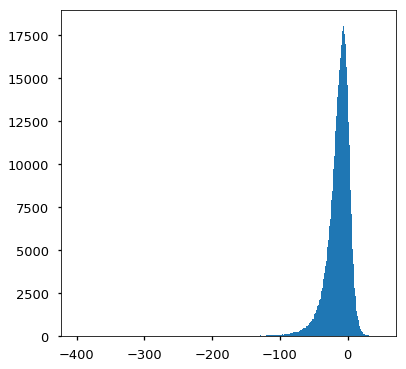

In [41]:
plt.figure()
_ = plt.hist(p10s['est'], bins=np.arange(-400, 50))
plt.show()

## quantile-quantile plots

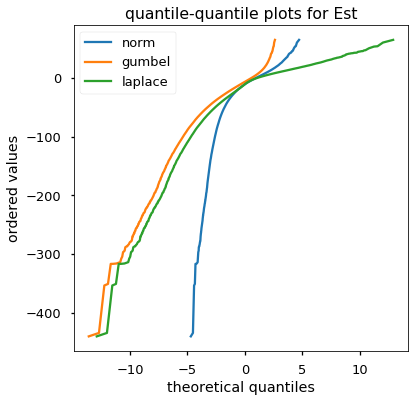

In [42]:
qq_norm, _ = stats.probplot(p10s['est'], dist=stats.norm)
qq_gumbel, _ = stats.probplot(p10s['est'], dist=stats.gumbel_l)
qq_laplace, _ = stats.probplot(p10s['est'], dist=stats.laplace)


plt.figure()
plt.plot(qq_norm[0], qq_norm[1], label='norm')
plt.plot(qq_gumbel[0], qq_gumbel[1], label='gumbel')
plt.plot(qq_laplace[0], qq_laplace[1], label='laplace')
plt.xlabel('theoretical quantiles')
plt.ylabel('ordered values')
plt.title('quantile-quantile plots for Est')
plt.legend()
plt.savefig('figures/est_quantiles.pdf', format='pdf')
plt.show()

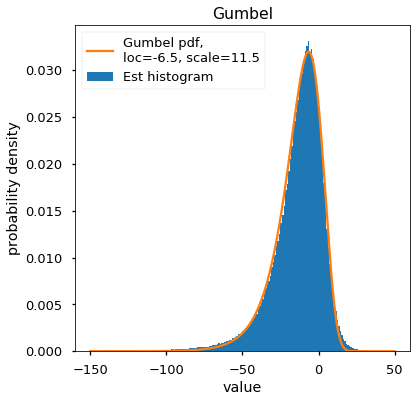

In [9]:
# just plot Gumbel pdf
loc = -6.5
scale = 11.5
x = np.linspace(-150, 50, 1000)
plt.figure()
_ = plt.hist(p10s['est'], bins=np.arange(-150, 50), density=True, label='Est histogram')
plt.plot(x, stats.gumbel_l.pdf(x, loc, scale), label=('Gumbel pdf,\nloc=%1.1f, scale=%1.1f' % (loc, scale)))
plt.xlabel('value')
plt.ylabel('probability density')
plt.title('Gumbel')
plt.legend(loc='upper left')
plt.savefig('figures/gumbel_est.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Auto-correlation (persistance forecasting)

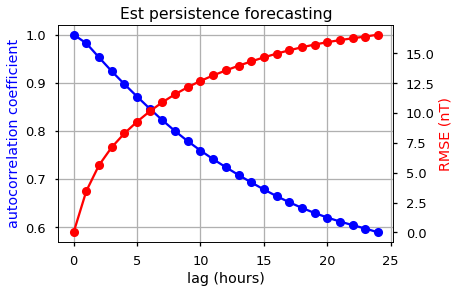

In [52]:
# compute autocorrelation
est_demean = p10s['est'].values - np.mean(p10s['est'].values)
corr = signal.correlate(est_demean, est_demean)/np.std(est_demean)**2/len(est_demean)
corr = corr[int(len(corr)/2):]

# compute RMSE of persistence forecasting
n_lags = 25
n_est = len(p10s)
lags = np.arange(n_lags)
rmse = np.zeros((n_lags, 1))
for ii in range(n_lags):
    idx_1 = slice(0, n_est-lags[ii])
    idx_2 = slice(lags[ii], n_est)
    rmse[ii] = np.sqrt(np.mean((p10s['est'].values[idx_1] - 
                                p10s['est'].values[idx_2])**2))

plt.figure(figsize=[6,4])
ax1 = plt.axes()
ax1.plot(corr[0:n_lags], 'bo-')
plt.grid()
ax2 = ax1.twinx()
ax2.plot(rmse, 'ro-')
ax1.set_ylabel('autocorrelation coefficient')
ax1.yaxis.label.set_color('blue')
ax1.set_xlabel('lag (hours)')
ax2.set_ylabel('RMSE (nT)')
ax2.yaxis.label.set_color('red')
plt.title('Est persistence forecasting')
plt.savefig('../figures/Est_persistence.pdf', bbox_inches='tight')